In [0]:
# Using google colab - this first step is for loading in the data from my personal Drive

# Login with google credentials

from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Handle errors from too many requests

import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

# The ID for my personal Drive folder is 1BVUuroPvozFxMjMIYrGOFtI4r6erSBCx
# I am now listing the ID numbers for the files in this folder to find the data files

#file_list = drive.ListFile({'q': "'1BVUuroPvozFxMjMIYrGOFtI4r6erSBCx' in parents and trashed=false"}).GetList()
#for file1 in file_list:
#  print('title: %s, id: %s' % (file1['title'], file1['id']))

# Data ID: 1F2KojI0d-ZnN8ssQFUWSyZA8I0mAgMEf

# Now that I have the ID files, load the files

data_downloaded = drive.CreateFile({'id': '1dwQLnIskShTXwSeMONhu__bYFf_f8-t6'})
data_downloaded.GetContentFile('sc_train.csv')

data_downloaded = drive.CreateFile({'id': '1IcNFIYUDKz1UxFL8W_JNjz9TzjAlAOVa'})
data_downloaded.GetContentFile('sc_unique_m.csv')


In [0]:
# Load the data into pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import io

train = pd.read_csv('sc_train.csv',low_memory=False, lineterminator='\n')
unique = pd.read_csv('sc_unique_m.csv',low_memory=False, lineterminator='\n')

In [0]:
unique.shape

(21263, 88)

In [0]:
import torch
from torch.nn import functional as F

class LinearRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        outputs = outputs.view(-1, 1)
        return outputs

In [0]:
# merge the two dataframes, drop material string
merge_df = pd.concat([train, unique], axis=1, sort=False)
merge_df = merge_df.drop(['material\r'], axis=1)
# Create feature identifying high-temp superconductors
merge_df['is_highTc'] = merge_df['critical_temp'] > 73

high_Tc_df = merge_df[merge_df['is_highTc']]

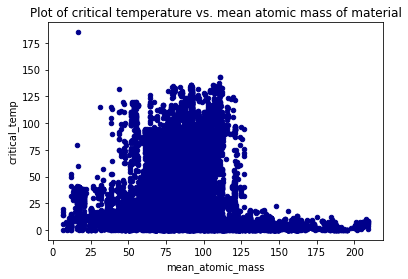

In [0]:
ax1 = merge_df.plot.scatter(x='mean_atomic_mass',
                      y='critical_temp',
                      c='DarkBlue',
                      title = 'Plot of critical temperature vs. mean atomic mass of material' )

In [0]:
merge_df.describe()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,std_Density,...,Cd,In,Sn,Sb,Te,I,Xe,Cs,Ba,La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,W,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp
count,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,...,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.0,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.0,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.0,21263.0,21263.0,21263.000000
mean,4.115224,87.557631,72.988310,71.290627,58.539916,1.165608,1.063884,115.601251,33.225218,44.391893,41.448045,769.614748,870.442317,737.474751,832.769649,1.299172,0.926726,572.222612,483.517264,215.631279,224.050033,157.983101,134.720039,144.448738,120.989330,1.267756,1.131138,139.325025,51.369885,51.601267,52.340465,6111.465214,5267.188547,3460.692235,3117.241110,1.072425,0.856037,8665.438818,2902.736814,3416.910784,...,0.009152,0.049468,0.120994,0.101269,0.040491,0.004744,0.0,0.004129,0.568440,0.264953,0.030662,0.041494,0.039666,0.0,0.021992,0.017821,0.023959,0.002857,0.009536,0.008832,0.014217,0.008909,0.012716,0.026849,0.009168,0.036086,0.010424,0.038206,0.022512,0.061558,0.034108,0.020535,0.036663,0.047954,0.042461,0.201009,0.0,0.0,0.0,34.421219
std,1.439295,29.676497,33.490406,31.030272,36.651067,0.364930,0.401423,54.626887,26.967752,20.035430,19.983544,87.488694,143.278200,78.327275,119.772520,0.381935,0.334018,309.614442,224.042874,109.966774,127.927104,20.147288,28.801567,22.090958,35.837843,0.375411,0.407159,67.272228,35.019356,22.898396,25.294524,2846.785185,3221.314506,3703.256370,3975.122587,0.342356,0.319761,4097.126831,2398.471020,1673.624915,...,0.688729,0.521820,1.886951,1.839020,0.718043,0.088480,0.0,0.077676,0.983288,2.320822,0.173147,1.282059,0.224657,0.0,0.183173,0.151433,0.155860,0.064737,0.104153,0.098728,0.131417,0.130455,0.214806,0.276861,0.208969,0.851380,0.164628,1.177476,0.282265,0.864859,0.307888,0.717975,0.205846,0.272298,0.274365,0.655927,0.0,0.0,0.0,34.254362
min,1.000000,6.941000,6.423452,5.320573,1.960849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,375.500000,375.500000,375.500000,375.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.000000,48.000000,48.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.429000,1.429000,1.429000,0.686245,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [0]:
high_Tc_df.describe()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,std_Density,...,Cd,In,Sn,Sb,Te,I,Xe,Cs,Ba,La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,W,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp
count,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,...,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.0,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.0,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.0,4371.000000,4371.000000,4371.0,4371.0,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.000000,4371.0,4371.0,4371.0,4371.000000
mean,5.179822,86.365804,62.356138,64.431741,43.645691,1.402256,1.384757,154.218169,22.459834,56.010229,51.810767,777.518240,937.901231,731.678627,880.484933,1.564564,1.092227,807.787074,563.371195,290.755206,317.201141,162.606096,125.876751,141.953005,104.369412,1.523968,1.443655,197.063830,35.518733,68.342793,71.840822,4923.526271,3660.440095,1019.533034,516.855620,1.253573,1.007049,10240.767475,2166.520098,3772.064269,...,0.002345,0.001487,0.000610,0.000746,0.000059,0.002546,0.0,0.001487,1.438218,0.045896,0.000629,0.010013,0.027934,0.0,0.015989,0.015040,0.035509,0.000849,0.015614,0.013397,0.025682,0.011780,0.027217,0.009222,0.000572,0.0,0.001018,0.001620,0.0,0.0,0.000036,0.001015,0.104285,0.122604,0.048842,0.399577,0.0,0.0,0.0,90.841521
std,0.936504,13.869704,15.820267,10.019089,14.870711,0.173161,0.157508,32.942899,10.558843,12.334160,10.255314,48.273422,116.101905,43.769505,101.691757,0.184260,0.259249,58.536662,197.773906,30.438954,47.321984,10.603756,23.136426,9.687582,26.624650,0.196100,0.151516,15.435295,15.511740,8.733149,10.238616,923.363440,1119.816307,330.514658,819.617843,0.198352,0.196961,2091.764140,716.796916,795.985315,...,0.041368,0.040746,0.013529,0.010045,0.002273,0.050132,0.0,0.030331,0.970476,0.264271,0.012343,0.060788,0.152258,0.0,0.212125,0.120602,0.177497,0.020262,0.120418,0.110601,0.153840,0.106911,0.293098,0.085697,0.009246,0.0,0.027304,0.016282,0.0,0.0,0.001738,0.021399,0.295811,0.413999,0.201864,0.873202,0.0,0.0,0.0,13.397331
min,2.000000,16.157213,11.360293,5.685033,3.193745,0.136394,0.155851,31.057060,5.555929,14.364556,5.137406,686.657143,539.440000,646.338636,526.433348,0.683983,0.284544,225.600000,43.555556,95.861567,29.874125,66.333333,64.333333,65.462500,62.520676,0.663360,0.197108,26.000000,4.403101,10.624918,3.089819,754.434633,653.393267,8.675703,2.511454,0.000504,0.000749,1959.910100,532.996688,979.955050,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,73.100000
25%,5.000000,76.444563,51.354450,59.356

In [0]:
# drop outlier
merge_df = merge_df[merge_df['critical_temp'] < 180]
merge_df.describe()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,std_Density,...,Cd,In,Sn,Sb,Te,I,Xe,Cs,Ba,La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,W,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp
count,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,...,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.0,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.0,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.000000,21262.0,21262.0,21262.0,21262.000000
mean,4.115323,87.560971,72.991209,71.293713,58.542519,1.165656,1.063923,115.605228,33.226309,44.393251,41.449306,769.596616,870.426479,737.455605,832.752488,1.299201,0.926742,572.234837,483.514551,215.634077,224.053647,157.987239,134.723350,144.452338,120.992080,1.267784,1.131159,139.329978,51.372003,51.602894,52.342173,6111.706557,5267.405544,3460.854375,3117.387603,1.072475,0.856077,8665.754194,2902.842612,3417.025400,...,0.009153,0.049471,0.121000,0.101274,0.040493,0.004745,0.0,0.004129,0.568467,0.264965,0.030663,0.041496,0.039668,0.0,0.021993,0.017822,0.023960,0.002857,0.009537,0.008832,0.014218,0.008910,0.012716,0.026850,0.009169,0.036088,0.010424,0.038208,0.022513,0.061561,0.034110,0.020536,0.036665,0.047956,0.042463,0.201019,0.0,0.0,0.0,34.414137
std,1.439255,29.673198,33.488527,31.027739,36.649963,0.364871,0.401392,54.625095,26.967916,20.034924,19.983168,87.450787,143.262954,78.279348,119.749194,0.381920,0.334017,309.616591,224.047793,109.968604,127.929027,20.138724,28.798199,22.085239,35.836443,0.375397,0.407157,67.269932,35.018818,22.897705,25.293893,2846.634595,3221.234847,3703.267984,3975.158673,0.342285,0.319714,4096.965078,2398.477808,1673.580820,...,0.688745,0.521833,1.886995,1.839063,0.718060,0.088482,0.0,0.077678,0.983303,2.320876,0.173151,1.282089,0.224662,0.0,0.183177,0.151436,0.155864,0.064738,0.104156,0.098730,0.131420,0.130458,0.214812,0.276868,0.208974,0.851400,0.164632,1.177504,0.282272,0.864879,0.307895,0.717992,0.205851,0.272304,0.274371,0.655941,0.0,0.0,0.0,34.239597
min,1.000000,6.941000,6.423452,5.320573,1.960849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,375.500000,375.500000,375.500000,375.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.000000,48.000000,48.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.429000,1.429000,1.429000,0.686245,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [0]:

#normalize
merge_df = (merge_df-merge_df.min())/(merge_df.max()-merge_df.min())
# fix any NA values created by division by zero
merge_df = merge_df.fillna(0)

In [0]:
#drop cols with one value
for col in merge_df.columns:
    if len(merge_df[col].unique()) == 1:
        merge_df.drop(col,inplace=True,axis=1)

In [0]:
#print(merge_df.nunique())

## 9 columns with only 1 value

In [0]:
# Create correlation matrix

features = list(merge_df.columns.values.tolist())
corrMat = merge_df[features].corr().abs()

# Select upper triangle of correlation matrix
upper = corrMat.where(np.triu(np.ones(corrMat.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.2)]

# make sure I don't drop my target variables
if 'critical_temp' in to_drop: to_drop.remove('critical_temp')
if 'is_highTc' in to_drop: to_drop.remove('is_highTc')

In [0]:
print(len(to_drop)) # 55
#to_drop

merge_df = merge_df.drop(merge_df[to_drop], axis=1)

114


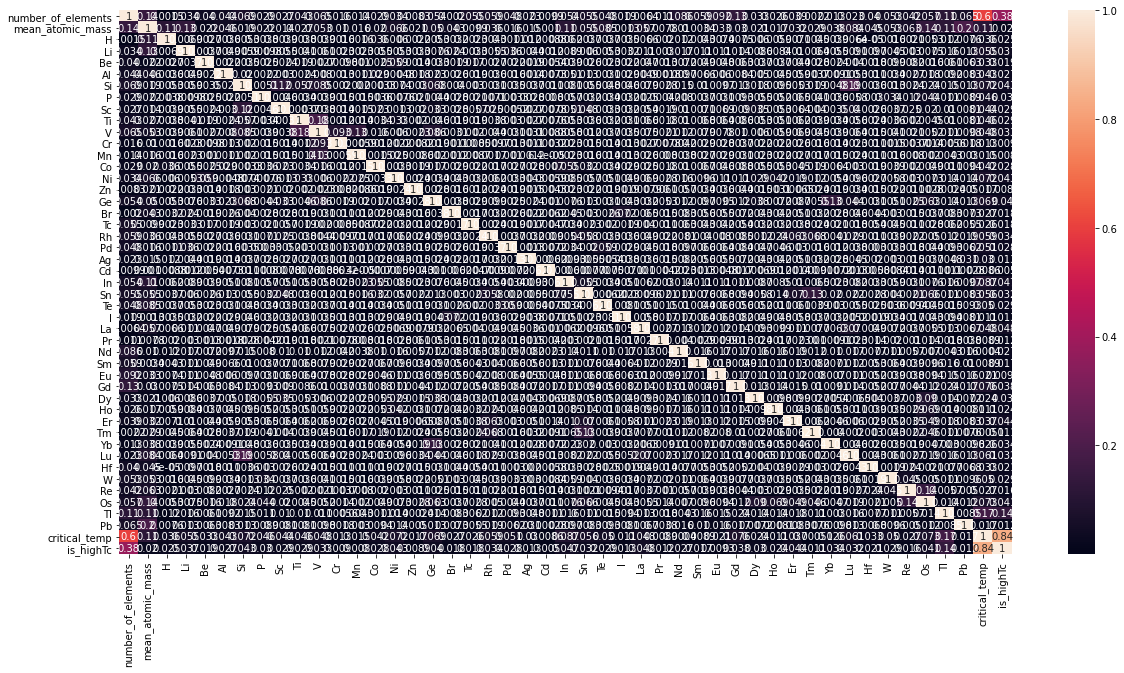

In [0]:
import seaborn as sn

features = list(merge_df.columns.values.tolist())
corrMat = merge_df[features].corr().abs()

plt.figure(figsize=(20,10))
sn.heatmap(corrMat, annot=True)

In [0]:
## train test split

train_df = merge_df.sample(frac=0.8, random_state=np.random.seed())
test_df = merge_df.drop(train_df.index)

# set up train and test data
X_train = train_df.drop(['critical_temp', 'is_highTc'], axis=1).to_numpy()
X_test = test_df.drop(['critical_temp', 'is_highTc'], axis=1).to_numpy()

X_train_high = train_df[train_df['is_highTc'] == 1].drop(['critical_temp', 'is_highTc'], axis=1).to_numpy()
X_test_high = test_df[test_df['is_highTc'] == 1].drop(['critical_temp', 'is_highTc'], axis=1).to_numpy()

# set up target variable
y_train = train_df['critical_temp'].to_numpy()
y_test = test_df['critical_temp'].to_numpy()

# Set up alternative target - is high_T SC or not
y_high_temp_train = train_df['is_highTc'].to_numpy()
y_high_temp_test = test_df['is_highTc'].to_numpy()
#convert to Torch

X_torch = torch.from_numpy(X_train).float()
X_torch_high = torch.from_numpy(X_train_high).float()
y_torch = torch.from_numpy(y_train).float()
y_torch_highTC = torch.from_numpy(y_high_temp_train).float()
type(X_torch)

print(sum(sum(torch.isnan(X_torch))))

## No nans

tensor(0)


In [0]:
input_dim = X_train.shape[1]
output_dim = 1
lr_rate = 1e-3

In [0]:
y_train*185

array([  8.02071912,  32.34243316,  10.09065223, ...,  20.69905942,
       104.53135036, 115.13975755])

In [0]:
def MAPELoss(output, target):
  return 100*torch.mean(torch.abs((target - output) / (target + 0.001)))

def rmse(y, y_hat):

  #combined rmse value
  mse=torch.mean((y-y_hat)**2)
  rmse = torch.sqrt(mse)

  return rmse

In [0]:
# Linear model on all data
epochs = 2000
model = LinearRegression(input_dim, output_dim)

use_cuda = torch.cuda.is_available()

if use_cuda:
    print("Using GPU!")
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    model.cuda()
    X_torch = X_torch.to(device)
    y_torch = y_torch.to(device)
else:
  print("Using CPU!")

criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

for epoch in range(epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(X_torch)
    #print(X_torch)
    #print(y_pred)
    #print(y_torch)
    # Compute and print loss
    loss = criterion(y_pred, y_torch)
    if epoch % 100 == 0: 
      print(epoch, loss.item(), rmse(y_pred, y_torch))


    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Using GPU!
0 0.12962457537651062 tensor(0.3600, device='cuda:0', grad_fn=<SqrtBackward>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([17010])) that is different to the input size (torch.Size([17010, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


100 0.10028598457574844 tensor(0.3167, device='cuda:0', grad_fn=<SqrtBackward>)
200 0.08297090232372284 tensor(0.2880, device='cuda:0', grad_fn=<SqrtBackward>)
300 0.07275111973285675 tensor(0.2697, device='cuda:0', grad_fn=<SqrtBackward>)
400 0.06671841442584991 tensor(0.2583, device='cuda:0', grad_fn=<SqrtBackward>)
500 0.06315656751394272 tensor(0.2513, device='cuda:0', grad_fn=<SqrtBackward>)
600 0.061052847653627396 tensor(0.2471, device='cuda:0', grad_fn=<SqrtBackward>)
700 0.05980958789587021 tensor(0.2446, device='cuda:0', grad_fn=<SqrtBackward>)
800 0.059074122458696365 tensor(0.2431, device='cuda:0', grad_fn=<SqrtBackward>)
900 0.058638330549001694 tensor(0.2422, device='cuda:0', grad_fn=<SqrtBackward>)
1000 0.05837938189506531 tensor(0.2416, device='cuda:0', grad_fn=<SqrtBackward>)
1100 0.058224812150001526 tensor(0.2413, device='cuda:0', grad_fn=<SqrtBackward>)
1200 0.05813184753060341 tensor(0.2411, device='cuda:0', grad_fn=<SqrtBackward>)
1300 0.05807524919509888 tensor(0

In [0]:
print(MAPELoss(y_pred, y_torch))

tensor(712.1074, device='cuda:0', grad_fn=<MulBackward0>)


In [0]:
X_test_torch = torch.from_numpy(X_test).float()
y_test_torch = torch.from_numpy(y_test.reshape(len(y_test))).float()

print("Test set!")

if use_cuda:
    print("Using GPU!")
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    model.cuda()
    X_test_torch = X_test_torch.to(device)
    y_test_torch = y_test_torch.to(device)
else:
  print("Using CPU!")

test_preds = model(X_test_torch)
testLoss = criterion(test_preds, y_test_torch)
print(loss.item(), rmse(y_pred, y_torch))



Test set!
Using GPU!
0.05797269940376282 tensor(0.2408, device='cuda:0', grad_fn=<SqrtBackward>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([4252])) that is different to the input size (torch.Size([4252, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [0]:
test_preds

tensor([[0.2370],
        [0.2637],
        [0.2358],
        ...,
        [0.2437],
        [0.2259],
        [0.2312]], device='cuda:0', grad_fn=<ViewBackward>)

In [0]:
def getImportanceTable(weights, features):

  weights_array = weights.tolist()
  weights_array = [item for sublist in weights_array for item in sublist]
  #weights_array = weights_array[1:]
  weights_sum = sum(list(map(abs, weights_array)))

  weights_array[:] = [x / weights_sum for x in weights_array]

  importances = list(zip(features, weights_array))
  importances = sorted(importances, key=lambda x : x[1], reverse=True)
  #importances = sorted(importances, key=lambda x : abs(x[1]), reverse=True)

  num = np.array(importances)
  reshaped = num.reshape(len(features),2)
  importanceTable = pd.DataFrame(reshaped, columns=['Feature','Importance'])

  return importanceTable

In [0]:
s = model.linear.weight.data.cpu().numpy()
importanceTable = getImportanceTable(s, train_df.drop(['critical_temp', 'is_highTc'], axis=1).columns)

importanceTable

,Feature,Importance
0,P,0.0421643396904583
1,Pr,0.041064281556999704
2,I,0.04019999882155142
3,mean_atomic_mass,0.038317976918262206
4,Rh,0.03582992634589807
5,Sn,0.03577510701287472
6,Gd,0.030568255718466584
7,Co,0.02860816039184059
8,number_of_elements,0.02743063717712784
9,Sc,0.026538998326407555


In [0]:
# linear model on High-Tc data

epochs = 1000
model = LinearRegression(input_dim, output_dim)

use_cuda = torch.cuda.is_available()

if use_cuda:
    print("Using GPU!")
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    model.cuda()
    X_torch_high = X_torch_high.to(device)
    y_torch_highTC = y_torch_highTC.to(device)
else:
  print("Using CPU!")

criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

for epoch in range(epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(X_torch_high)
    #print(X_torch)
    #print(y_pred)
    #print(y_torch)
    # Compute and print loss
    loss = criterion(y_pred, y_torch_highTC)
    if epoch % 100 == 0: print(epoch, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

X_test_torch = torch.from_numpy(X_test_high).float()
y_test_torch_highTC = torch.from_numpy(y_high_temp_test).float()

print("Test set!")

if use_cuda:
    print("Using GPU!")
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    model.cuda()
    X_test_torch = X_test_torch.to(device)
    y_test_torch_highTC = y_test_torch_highTC.to(device)
else:
  print("Using CPU!")

test_preds = model(X_test_torch)
testLoss = criterion(test_preds, y_test_torch_highTC)
print(testLoss.item())

Using GPU!
0 0.25091254711151123


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([17010])) that is different to the input size (torch.Size([3499, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


100 0.21296431124210358
200 0.19156567752361298
300 0.17949886620044708
400 0.17269398272037506
500 0.16885614395141602
600 0.16669131815433502
700 0.16546986997127533
800 0.1647803634405136
900 0.16439080238342285
Test set!
Using GPU!
0.16357533633708954


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([4252])) that is different to the input size (torch.Size([871, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [0]:
s = model.linear.weight.data.cpu().numpy()
importanceTable = getImportanceTable(s, train_df.drop(['critical_temp', 'is_highTc'], axis=1).columns)

importanceTable

In [0]:
X_torch_high.shape

torch.Size([3499, 45])

In [0]:
import torch
from torch.nn import functional as F

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = F.softmax(self.linear(x))
        outputs = outputs.view(-1, 1)
        return outputs

In [0]:
# Logistic model - doesn't work

use_cuda = torch.cuda.is_available()
use_cuda = False

device = torch.device('cpu')

y_high_temp_train = train_df['is_highTc'].to_numpy()
y_high_temp_test = test_df['is_highTc'].to_numpy()
y_train_torch = torch.from_numpy(y_high_temp_train.reshape(len(y_train))).long()
y_test_torch = torch.from_numpy(y_high_temp_test.reshape(len(y_test))).long()

X_torch_high = torch.from_numpy(X_train).float()

epochs = 100
model = LinearRegression(input_dim, output_dim)



if use_cuda:
    print("Using GPU!")
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    model.cuda()
    X_torch_high = X_torch_high.to(device)
    y_train_torch = y_train_torch.to(device)
else:
  print("Using CPU!")

criterion = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

for epoch in range(epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(X_torch)
    #print(X_torch)
    #print(y_pred)
    #print(y_torch)
    # Compute and print loss
    loss = criterion(y_pred, y_train_torch)
    if epoch % 100 == 0: 
      print(epoch, loss.item(), rmse(y_pred, y_train_torch))

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

X_test_torch = torch.from_numpy(X_test_high).float()

print("Test set!")

if use_cuda:
    print("Using GPU!")
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    model.cuda()
    X_test_torch = X_test_torch.to(device)
    y_test_torch = y_test_torch.to(device)
else:
  print("Using CPU!")

test_preds = model(X_test_torch)
testLoss = criterion(test_preds, y_test_torch)
print(testLoss.item())
print(epoch, testLoss.item(), rmse(test_preds, y_test_torch))

In [0]:
y_torch_highTC

tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')